# SpaceX Falcon 9 First Stage Landing Prediction

## Project Overview

SpaceX’s ability to successfully recover and reuse the Falcon 9 first stage has significantly reduced the cost of space launches. Predicting whether the first stage will land successfully is therefore a critical factor in estimating launch costs and assessing mission feasibility.

In this notebook, a **machine learning pipeline** is developed to predict the **landing success of the Falcon 9 first stage** using historical launch data and engineered features derived from earlier stages of the project.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Machine Learning Workflow


The machine learning workflow implemented in this notebook includes:

- Defining the target variable representing landing success  
- Feature scaling and data standardization  
- Splitting the dataset into training and testing subsets  
- Training multiple classification models  
- Hyperparameter tuning for optimal performance  
- Evaluating models using accuracy and confusion matrices  


## Libraries and Utility Functions

The following libraries are used for data manipulation, visualization, and machine learning model development.

In [4]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn.preprocessing import StandardScaler
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.


In [5]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 


## Data Sources
Two datasets are used in this analysis:

- **`updated_data_falcon92`** – Cleaned and feature-engineered SpaceX launch dataset  
- **`Data_to_be_fed.csv`** – Model-ready dataset containing encoded and standardized features

These datasets are outputs of previous data collection, wrangling, and feature engineering steps in the project pipeline.

Load the data


In [6]:
data = pd.read_csv("updated_data_falcon92")

In [7]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [8]:
X = pd.read_csv('Data_to_be_fed.csv')

In [9]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## Label Creation


The target variable **Y** is created from the `Class` column in the dataset.  
This column represents whether the Falcon 9 first stage landed successfully.


In [10]:
Y=pd.Series(np.array(data['Class']))
Y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

## Train–Test Split

The dataset is split into training and testing subsets using a **70:30 ratio**.  
A fixed random state is used to ensure reproducibility of results.

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=101)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## Feature Standardization



To ensure all features contribute equally to model training, the input data is standardized using **StandardScaler**.  
Standardization improves convergence and performance for distance-based and margin-based models.

In [12]:
Scaler=StandardScaler()
X_train_S=Scaler.fit_transform(x_train)
X_test_S=Scaler.transform(x_test)

In [13]:
print(y_test.shape)
print(y_train.shape)
#the the training and the testing data has a split of 70:30

(27,)
(63,)


## Logistic Regression Mode


A Logistic Regression classifier is trained using GridSearchCV to identify the optimal hyperparameters.  
Class imbalance is addressed using `class_weight='balanced'`.


In [14]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}
logreg=LogisticRegression( class_weight='balanced')
Grid=GridSearchCV(logreg,parameters,n_jobs=-1,verbose=2,cv=10)
Grid.fit(X_train_S,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             verbose=2)

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [15]:
print("tuned hpyerparameters :(best parameters) ",Grid.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [16]:
print("accuracy :",Grid.best_score_)

accuracy : 0.8285714285714286


Lets look at the confusion matrix:


In [17]:
best_model_LogisticR=Grid.best_estimator_
best_model_LogisticR.fit(X_train_S,y_train)

LogisticRegression(C=0.1, class_weight='balanced')

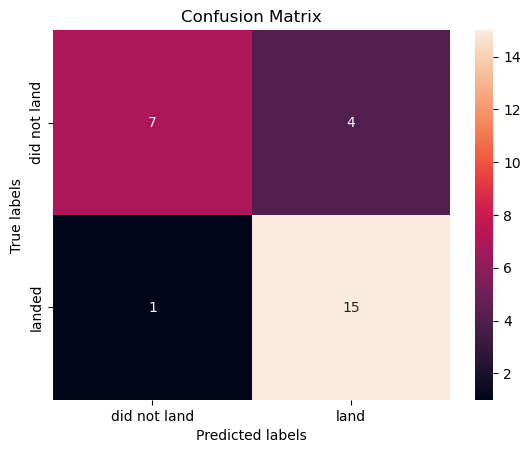

In [18]:
logistcPredict=best_model_LogisticR.predict(X_test_S)
plot_confusion_matrix(y_test,logistcPredict)

### Logistic Regression Evaluation

Although Logistic Regression achieves reasonable accuracy, it exhibits bias toward the majority class.  
This highlights the limitations of accuracy as a sole evaluation metric for imbalanced datasets.


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test,logistcPredict))

              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.79      0.94      0.86        16

    accuracy                           0.81        27
   macro avg       0.83      0.79      0.80        27
weighted avg       0.82      0.81      0.81        27



Due to class imbalance, the classifier learns that predicting the positive class most of the time maximizes accuracy. As a result, the model achieves perfect recall for successful landings but performs poorly in identifying failed landings, leading to a high number of false positives. This demonstrates the limitation of accuracy as an evaluation metric for imbalanced datasets

The classes were unbalanced so i set class_weight='balanced' which has made some serious improvement from before now the difference between the recall for the positive and the negative are 30% which is better then earlier, so from now on i will be using the class_weight='balanced' in all the remaining models to find the model with the best performence 

## Support Vector Machine (SVM)



A Support Vector Machine classifier is trained with extensive hyperparameter tuning.  
Balanced class weights are used to improve recall for minority classes.


In [20]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC(class_weight='balanced')
svm_cv=GridSearchCV(svm,parameters,n_jobs=-1,verbose=3,cv=10)
svm_cv.fit(X_train_S,y_train)

Fitting 10 folds for each of 125 candidates, totalling 1250 fits


GridSearchCV(cv=10, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             verbose=3)

In [21]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'C': np.float64(0.03162277660168379), 'gamma': np.float64(1.0), 'kernel': 'sigmoid'}


In [22]:
print("accuracy :",svm_cv.best_score_)

accuracy : 0.8619047619047618


We can plot the confusion matrix


In [23]:
best_model_svm=svm_cv.best_estimator_
best_model_svm.fit(X_train_S,y_train)

SVC(C=np.float64(0.03162277660168379), class_weight='balanced',
    gamma=np.float64(1.0), kernel='sigmoid')

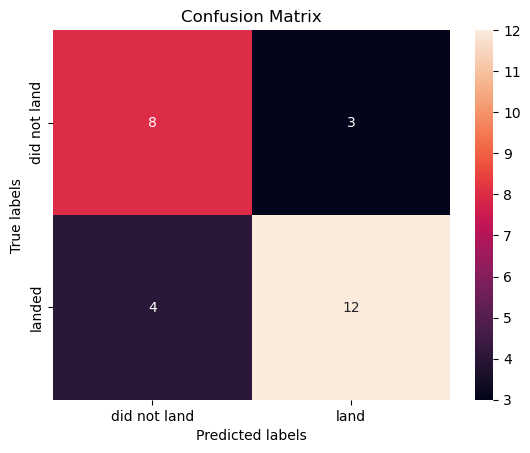

In [24]:
SVMPredict=best_model_svm.predict(X_test_S)
plot_confusion_matrix(y_test,SVMPredict)

### SVM Evaluation

The SVM model demonstrates the most balanced performance across both successful and failed landing classes, with minimal recall difference and strong macro-averaged F1-score.


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test,SVMPredict))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.80      0.75      0.77        16

    accuracy                           0.74        27
   macro avg       0.73      0.74      0.73        27
weighted avg       0.75      0.74      0.74        27



The Support Vector Machine classifier demonstrates the most balanced performance among the evaluated models. The recall values for failed and successful landings differ by only 2%, indicating minimal class bias. Although the overall accuracy is slightly lower than other models, the balanced recall and macro-averaged F1-score suggest that SVM generalizes better across both classes and is the most suitable model for this dataset.

## Decision Tree Classifier






A Decision Tree model is trained using GridSearchCV to optimize depth, splitting strategy, and feature selection.  
Class weighting is applied to mitigate imbalance.


In [26]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier( class_weight='balanced')
tree_cv=GridSearchCV(tree,parameters,cv=10,n_jobs=-1,verbose=3)
tree_cv.fit(X_train_S,y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


C:\Users\CG-DTE\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1632 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\CG-DTE\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\CG-DTE\anaconda3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\CG-DTE\anaconda3\Lib\site-packages\sklearn\base.py", line 436, in _validate_p

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             verbose=3)

In [27]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}


In [28]:
print("accuracy :",tree_cv.best_score_)

accuracy : 0.8761904761904763


In [29]:
best_model_tree=tree_cv.best_estimator_
tree_predict=best_model_tree.predict(X_test_S)

We can plot the confusion matrix


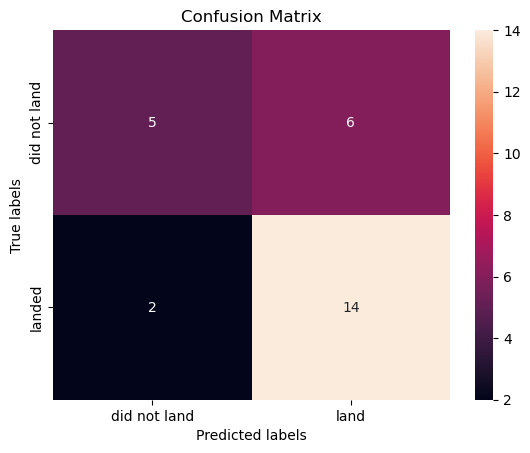

In [30]:
plot_confusion_matrix(y_test,tree_predict)

### Decision Tree Evaluation

While Decision Trees achieve high accuracy, they show greater disparity between class recall values compared to SVM, indicating moderate class bias.


In [31]:
print(classification_report(y_test,tree_predict))

              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.70      0.88      0.78        16

    accuracy                           0.70        27
   macro avg       0.71      0.66      0.67        27
weighted avg       0.71      0.70      0.69        27



After applying class balancing, the Decision Tree classifier showed improved performance in identifying failed landings. However, compared to the Support Vector Machine, it still exhibited a larger disparity between recall values for the two classes. Although both models achieved similar macro-averaged F1-scores, SVM demonstrated more balanced class-wise performance, making it the preferred model for this task.

## K-Nearest Neighbors (KNN)




The KNN classifier is evaluated using different neighbor counts and distance metrics.  
GridSearchCV is used to identify the optimal configuration.

In [32]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv=GridSearchCV(KNN,parameters,n_jobs=-1,cv=10,verbose=2)
knn_cv.fit(X_train_S,y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             verbose=2)

In [33]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}


In [34]:
print("accuracy :",knn_cv.best_score_)

accuracy : 0.8761904761904763


In [35]:
best_model_knn=knn_cv.best_estimator_

We can plot the confusion matrix


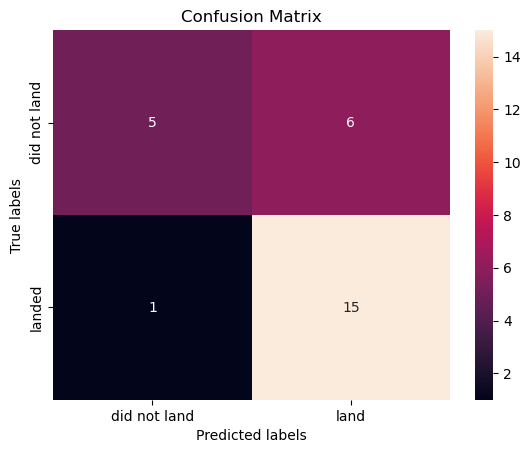

In [36]:
predict_knn = best_model_knn.predict(X_test_S)
plot_confusion_matrix(y_test,predict_knn)

In [37]:
print(classification_report(y_test,predict_knn))

              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.71      0.94      0.81        16

    accuracy                           0.74        27
   macro avg       0.77      0.70      0.70        27
weighted avg       0.76      0.74      0.72        27



## Model Comparison & Final Selection



Among all evaluated models, the **Support Vector Machine (SVM)** demonstrates the best overall performance:

- Smallest recall difference between classes (~2%)
- Most balanced class-wise predictions
- Strong macro-averaged F1-score
- Lowest bias toward the majority class

Although some models achieve higher raw accuracy, SVM provides the most reliable and fair performance for this imbalanced classification problem. Therefore, **SVM is selected as the final model** for predicting Falcon 9 first-stage landing success.


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>
